In [32]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.svm import SVC

# Load data

In [3]:
X = pd.read_csv('./data/hcvdat0.csv', index_col=0).reset_index(drop=True)

# Pre-processing

In this first part, we need to change the ``category`` attribute of the data because we need it to be int. In addition, we change the ``Sex`` attribute from m/f to $0/1$. All the other attributes are already floats, so we keep them as they are.

> m $\rightarrow 0$ and f $\rightarrow 1$

> Blood donor $\rightarrow 0$, Suspect blood donor $\rightarrow 1$, Hepatitis $\rightarrow 2$, Fibrosis $\rightarrow 3$ and Cirrhosis $\rightarrow 4$

## Change the sex and category attributes

In [4]:
class_names = np.unique(X.Category)
X = X.replace({'Sex': {'f':1,'m':0}, 'Category':{'0=Blood Donor':0,'0s=suspect Blood Donor':1, '1=Hepatitis':2, '2=Fibrosis':3, '3=Cirrhosis':4}})

## Remove NaN values

In [5]:
X = X.dropna()

## Split X and y

In [6]:
y = X.Category
X = X.drop('Category', axis=1)

## Split the data in train and test split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

# Decision tree

## Build the tree

In [8]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

## Compute the accuracy of the tree

In [10]:
y_pred_train = clf.predict(x_train)
accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
print('Accuracy on the train set:', accuracy_train)

y_pred_test = clf.predict(x_test)
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
print('Accuracy on the test set:', accuracy_test)

Accuracy on the train set: 0.9682539682539683
Accuracy on the test set: 0.9121621621621622


## Visualise the tree

In [11]:
feature_names = X.columns
plot_tree = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, feature_names=feature_names, class_names=class_names)
graph = graphviz.Source(plot_tree)

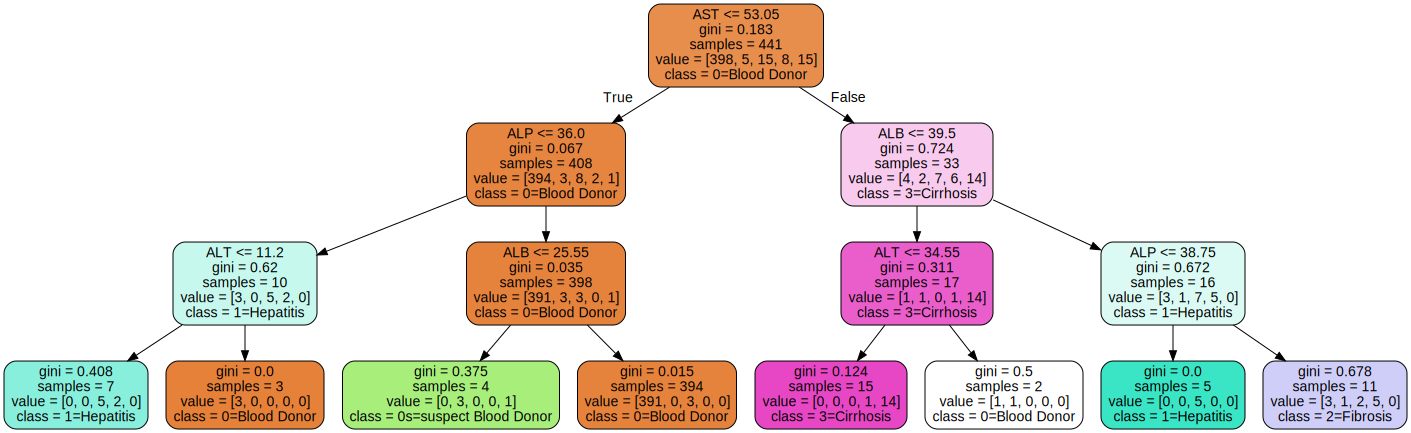

In [12]:
graph

Use ``graph.render('name of the graph', view=True)`` when one wants to save the graph in a pdf file in the same directory as the one containing this notebook.

# SVM

## One versus one classification

In [15]:
clf_ovo = SVC(decision_function_shape='ovo')
clf_ovo.fit(x_train, y_train)

SVC(decision_function_shape='ovo')

In [16]:
clf_ovo.score(x_test, y_test)

0.918918918918919

## One versus rest classification

In [17]:
clf_ovr = SVC(decision_function_shape='ovr')
clf_ovr.fit(x_train, y_train)

SVC()

In [18]:
clf_ovr.score(x_test, y_test)

0.918918918918919

We obtain the same results with the two different methods

# Neural Network

In [24]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import optimizers
from keras.utils.np_utils import to_categorical

In [25]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [57]:
model = Sequential()

model.add(Dense(units = 12, activation='relu', input_dim=12))
model.add(Dense(units = 8, activation='sigmoid'))
model.add(Dense(units = 5, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [58]:
history = model.fit(x_train, y_train, batch_size = 2, epochs = 20, validation_data=(x_test, y_test), verbose=1)

Epoch 1/20
221/221 [==============================] - 1s 2ms/step - loss: 0.8271 - accuracy: 0.8842 - val_loss: 1.0148 - val_accuracy: 0.8649
Epoch 2/20
221/221 [==============================] - 0s 2ms/step - loss: 0.4640 - accuracy: 0.9021 - val_loss: 0.8585 - val_accuracy: 0.8649
Epoch 3/20
221/221 [==============================] - 0s 1ms/step - loss: 0.4077 - accuracy: 0.9080 - val_loss: 0.8020 - val_accuracy: 0.8649
Epoch 4/20
221/221 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.8944 - val_loss: 0.7580 - val_accuracy: 0.8649
Epoch 5/20
221/221 [==============================] - 0s 1ms/step - loss: 0.3140 - accuracy: 0.9244 - val_loss: 0.7072 - val_accuracy: 0.8649
Epoch 6/20
221/221 [==============================] - 0s 1ms/step - loss: 0.3511 - accuracy: 0.9083 - val_loss: 0.6234 - val_accuracy: 0.8649
Epoch 7/20
221/221 [==============================] - 0s 1ms/step - loss: 0.2918 - accuracy: 0.9185 - val_loss: 0.5584 - val_accuracy: 0.8649
Epoch 

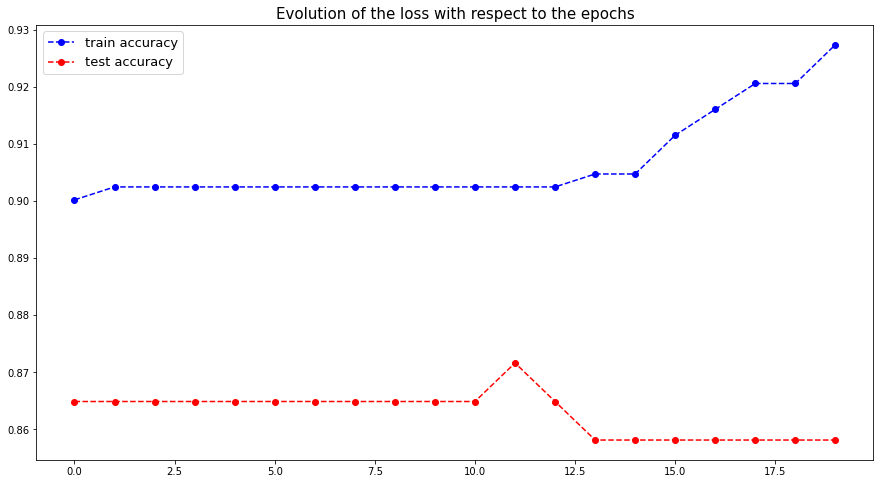

In [59]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
plt.figure(figsize=(15,8))
plt.plot(loss, c='b', marker='o', linestyle='--', label='train accuracy')
plt.plot(val_loss, c='r', marker='o', linestyle='--', label='test accuracy')
plt.title('Evolution of the loss with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()